## Setup

In [1]:
# GPU Configuration - Use P100 (GPU 1) for best performance
import os

# Set library path for CUDA libraries installed via pip
venv_cuda_libs = '/mnt/arkk/kaggle/diabetes-prediction/.venv/lib/python3.12/site-packages/nvidia/cudnn/lib'

if 'LD_LIBRARY_PATH' in os.environ:
    os.environ['LD_LIBRARY_PATH'] = f"{os.environ['LD_LIBRARY_PATH']}:{venv_cuda_libs}"

else:
    os.environ['LD_LIBRARY_PATH'] = venv_cuda_libs

os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # 1=GTX1080, 0=P100
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Verify GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {gpus}")
print(f"Number of GPUs: {len(gpus)}")

2025-12-08 12:11:49.839427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765213909.863454 1891645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765213909.870916 1891645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs: 1


In [2]:
# Standard imports
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.metrics import roc_auc_score

# Add functions to path
sys.path.insert(0, str(Path('.').resolve()))

# Import ensemble modules - use same optimization function as online path!
from functions.ensemble_initialization import create_data_splits
from functions.ensemble_stage2_training import optimize_and_update_config
from functions import ensemble_config

### Configuration

In [3]:
# Configuration
RANDOM_STATE = 315
LABEL = 'diagnosed_diabetes'

# Hyperparameter search settings - FAST configuration to prevent hanging
MAX_TRIALS = 10  # Reduced from 50 (was causing 7+ hour hangs)
EXECUTIONS_PER_TRIAL = 1  # Reduced from 3 (statistical confidence not critical)

### Anti-Overfitting Strategy

**Problem observed:** Validation loss increases while training loss decreases = overfitting

**Root cause:** With only 5 Stage 1 models, Stage 2 input is very low-dimensional (5 features) making overfitting easy

**Data split updated:** 60-35-5 (was 60-20-20)
- More data (35% vs 20%) for Stage 1 validation & Stage 2 training
- Smaller final holdout (5% vs 20%) - adequate for final evaluation

**Solutions to test:**
1. **Simpler architectures**: Fewer layers, smaller units (32-64 vs 64-256)
2. **Higher dropout**: 0.4-0.7 range instead of 0.2-0.5
3. **L2 regularization**: Add weight decay to dense layers
4. **Lower learning rate**: Better generalization (1e-5 to 1e-4)
5. **Early stopping on val_loss**: Stop when validation degrades

In [ ]:
# Updated hyperparameter search settings - ANTI-OVERFITTING FOCUS
MAX_TRIALS = 15  # Slightly more trials for better search
EXECUTIONS_PER_TRIAL = 2  # More executions for statistical reliability

# Override the optimization function to use anti-overfitting settings
from tensorflow.keras import regularizers

def build_regularized_model(hp, n_models):
    """Build model with strong regularization to prevent overfitting."""
    from tensorflow.keras import models, layers
    
    # Simpler architectures - prefer fewer, smaller layers
    arch_type = hp.Choice('architecture_type', values=['funnel'])  # Funnel only - better for small datasets
    n_layers = hp.Int('n_layers', min_value=1, max_value=2)  # Max 2 layers
    base_units = hp.Choice('base_units', values=[32, 64])  # Smaller units
    
    # Strong regularization
    dropout = hp.Float('dropout', min_value=0.4, max_value=0.7)  # Higher dropout
    l2_reg = hp.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')  # L2 regularization
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='log')  # Lower LR
    
    # Generate layer units
    if arch_type == 'funnel':
        if n_layers == 1:
            units_per_layer = [base_units]
        else:  # n_layers == 2
            units_per_layer = [base_units, base_units // 2]
    
    # Build model
    model = models.Sequential()
    model.add(layers.Input(shape=(n_models,)))
    
    for units in units_per_layer:
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)  # Add L2 regularization
        ))
        model.add(layers.Dropout(dropout))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc')]
    )
    
    return model, {
        'architecture_type': arch_type,
        'n_layers': n_layers,
        'base_units': base_units,
        'units_per_layer': units_per_layer,
        'dropout': dropout,
        'l2_reg': l2_reg,
        'learning_rate': learning_rate
    }

print("Anti-overfitting configuration loaded!")
print(f"  Max trials: {MAX_TRIALS}")
print(f"  Executions per trial: {EXECUTIONS_PER_TRIAL}")
print(f"  Architecture: Funnel only (1-2 layers)")
print(f"  Units: 32-64 (smaller)")
print(f"  Dropout: 0.4-0.7 (higher)")
print(f"  L2 regularization: 1e-4 to 1e-2")
print(f"  Learning rate: 1e-5 to 1e-4 (lower)")

## Data Preparation

In [4]:
# Load training data
train_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv'
train_df = pd.read_csv(train_df_path)
train_df.drop_duplicates(inplace=True)

print(f'Training data shape: {train_df.shape}')
print(f'Class distribution:')
print(train_df[LABEL].value_counts(normalize=True))

Training data shape: (700000, 26)
Class distribution:
diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


In [ ]:
# Create 60/35/5 split (same as hill climbing)
X_train_pool, X_val_s1, X_val_s2, y_train_pool, y_val_s1, y_val_s2 = create_data_splits(
    train_df, LABEL, RANDOM_STATE
)

print(f"\nData splits (same as hill climbing):")
print(f"  X_train_pool: {X_train_pool.shape} (60%)")
print(f"  X_val_s1: {X_val_s1.shape} (35%)")
print(f"  X_val_s2: {X_val_s2.shape} (5%)")


Data splits (same as hill climbing):
  X_train_pool: (420000, 25) (60%)
  X_val_s1: (140000, 25) (20%)
  X_val_s2: (140000, 25) (20%)


## Load Stage 1 Models from prior ensemble run.

In [6]:
import joblib
from glob import glob

models_path = f"../models/run_20251208_045148/ensemble_stage1_models"

print(f"Loading models from: {models_path}\n")

# Find all model files (excluding founder)
model_files = sorted(glob(f"{models_path}/model_*.joblib"))

# Load first 5 models
stage1_models = []

for model_file in model_files[:5]:
    model_name = Path(model_file).stem
    model = joblib.load(model_file)
    
    # Evaluate on validation set
    # Handle both predict_proba and decision_function (e.g., LinearSVC)
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_val_s1)[:, 1]

    else:
        # Use decision_function for models like LinearSVC
        pred = model.decision_function(X_val_s1)
    
    auc = roc_auc_score(y_val_s1, pred)
    
    stage1_models.append(model)
    print(f"  {model_name}: AUC = {auc:.6f}")

print(f"\n{len(stage1_models)} Stage 1 models loaded!")
print(f"Model files: {[Path(f).stem for f in model_files[:5]]}")

Loading models from: ../models/run_20251208_045148/ensemble_stage1_models

  model_10: AUC = 0.523824
  model_10: AUC = 0.523824
  model_11: AUC = 0.583371
  model_11: AUC = 0.583371
  model_12: AUC = 0.648862
  model_12: AUC = 0.648862
  model_3: AUC = 0.576894
  model_3: AUC = 0.576894
  model_9: AUC = 0.622577

5 Stage 1 models loaded!
Model files: ['model_10', 'model_11', 'model_12', 'model_3', 'model_9']
  model_9: AUC = 0.622577

5 Stage 1 models loaded!
Model files: ['model_10', 'model_11', 'model_12', 'model_3', 'model_9']


## Custom Regularized Optimization

Run custom hyperparameter search with anti-overfitting focus.

In [ ]:
import time
from pathlib import Path

print("=" * 80)
print(f"STARTING REGULARIZED OPTIMIZATION")
print(f"Settings: {MAX_TRIALS} trials × {EXECUTIONS_PER_TRIAL} execution(s)")
print("=" * 80)

# Prepare data for optimization (50% sample - larger for better hyperparameter search)
sample_size = int(len(X_val_s1) * 0.5)
X_val_s1_sample = X_val_s1.iloc[:sample_size]
y_val_s1_sample = y_val_s1.iloc[:sample_size]

sample_size_s2 = int(len(X_val_s2) * 0.5)
X_val_s2_sample = X_val_s2.iloc[:sample_size_s2]
y_val_s2_sample = y_val_s2.iloc[:sample_size_s2]

print(f"Using 50% sample for optimization (better than 10%):")
print(f"  X_val_s1_sample: {X_val_s1_sample.shape} (50% of {X_val_s1.shape[0]:,})")
print(f"  X_val_s2_sample: {X_val_s2_sample.shape} (50% of {X_val_s2.shape[0]:,})")
print()

# Generate Stage 1 predictions
all_stage1_preds_s1 = []
for model in stage1_models:
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_val_s1_sample)[:, 1]
    else:
        pred = model.decision_function(X_val_s1_sample)
    all_stage1_preds_s1.append(pred)

all_stage1_preds_s2 = []
for model in stage1_models:
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_val_s2_sample)[:, 1]
    else:
        pred = model.decision_function(X_val_s2_sample)
    all_stage1_preds_s2.append(pred)

X_stage2_s1 = np.column_stack(all_stage1_preds_s1)
X_stage2_s2 = np.column_stack(all_stage1_preds_s2)
y_stage2_s1 = y_val_s1_sample.values
y_stage2_s2 = y_val_s2_sample.values

# 90/10 split
split_idx = int(len(X_stage2_s2) * 0.9)
X_train_opt = np.vstack([X_stage2_s1, X_stage2_s2[:split_idx]])
y_train_opt = np.concatenate([y_stage2_s1, y_stage2_s2[:split_idx]])
X_val_opt = X_stage2_s2[split_idx:]
y_val_opt = y_stage2_s2[split_idx:]

print(f"Training samples: {len(X_train_opt):,}")
print(f"Validation samples: {len(X_val_opt):,}")
print()

# Run custom optimization
from keras_tuner import RandomSearch, Objective
from tensorflow.keras import callbacks

n_models = X_train_opt.shape[1]
tuner_dir = Path('../models/keras_tuner')
tuner_dir.mkdir(parents=True, exist_ok=True)

def build_model_wrapper(hp):
    """Wrapper for Keras Tuner."""
    model, hps = build_regularized_model(hp, n_models)
    return model

tuner = RandomSearch(
    build_model_wrapper,
    objective=Objective('val_loss', direction='min'),  # Optimize val_loss, not AUC!
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory=str(tuner_dir),
    project_name='stage2_regularized_tuning',
    overwrite=True
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor val_loss
    patience=10,
    mode='min',
    restore_best_weights=True
)

start_time = time.time()

tuner.search(
    X_train_opt, y_train_opt,
    epochs=100,
    validation_data=(X_val_opt, y_val_opt),
    callbacks=[early_stop],
    verbose=1,
    batch_size=64  # Smaller batch size for better generalization
)

elapsed_time = time.time() - start_time

# Get best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate
y_pred_val = best_model.predict(X_val_opt, verbose=0).flatten()
val_auc = roc_auc_score(y_val_opt, y_pred_val)

print("\n" + "=" * 80)
print("OPTIMIZATION COMPLETE")
print("=" * 80)
print(f"Elapsed time: {elapsed_time/60:.1f} minutes")
print(f"Best validation AUC: {val_auc:.6f}")
print(f"Architecture: {best_hps.get('architecture_type')}")
print(f"Layers: {best_hps.get('n_layers')}")
print(f"Base units: {best_hps.get('base_units')}")
print(f"Dropout: {best_hps.get('dropout'):.3f}")
print(f"L2 reg: {best_hps.get('l2_reg'):.6f}")
print(f"Learning rate: {best_hps.get('learning_rate'):.6f}")
print("=" * 80)

# Store best hyperparameters for retraining
optimized_hps = {
    'architecture_type': best_hps.get('architecture_type'),
    'n_layers': best_hps.get('n_layers'),
    'base_units': best_hps.get('base_units'),
    'dropout': best_hps.get('dropout'),
    'l2_reg': best_hps.get('l2_reg'),
    'learning_rate': best_hps.get('learning_rate')
}

Trial 10 Complete [00h 01m 11s]
val_auc: 0.6767421960830688

Best val_auc So Far: 0.6768959164619446
Total elapsed time: 00h 09m 16s
  Tuner search complete! Extracting best model...


/mnt/arkk/kaggle/diabetes-prediction/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



  Optimization complete!
  Best hyperparameters:
    - Architecture: funnel
    - Layers: 2 ([8, 128])
    - Dropout: 0.454
    - Learning rate: 0.000431
  Validation AUC: 0.676679
  Config updated in-memory for subsequent training


OPTIMIZATION COMPLETE
Elapsed time: 9.3 minutes (560 seconds)
Average time per trial: 56.0 seconds


## Retrain on Full Dataset

Now retrain the best model on the complete dataset to get final performance and learning curves.

In [9]:
# Generate Stage 1 predictions on ALL data (both validation sets)
print("Generating Stage 1 predictions on full validation set...")

all_stage1_preds_s1 = []
for model in stage1_models:
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_val_s1)[:, 1]
    else:
        pred = model.decision_function(X_val_s1)
    all_stage1_preds_s1.append(pred)

all_stage1_preds_s2 = []
for model in stage1_models:
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_val_s2)[:, 1]
    else:
        pred = model.decision_function(X_val_s2)
    all_stage1_preds_s2.append(pred)

# Stack predictions
X_stage2_s1 = np.column_stack(all_stage1_preds_s1)
X_stage2_s2 = np.column_stack(all_stage1_preds_s2)
y_stage2_s1 = y_val_s1.values
y_stage2_s2 = y_val_s2.values

# Use 90/10 split for train/val
split_idx = int(len(X_stage2_s2) * 0.9)
X_stage2_s2_train = X_stage2_s2[:split_idx]
X_stage2_s2_val = X_stage2_s2[split_idx:]
y_stage2_s2_train = y_stage2_s2[:split_idx]
y_stage2_s2_val = y_stage2_s2[split_idx:]

X_train_full = np.vstack([X_stage2_s1, X_stage2_s2_train])
y_train_full = np.concatenate([y_stage2_s1, y_stage2_s2_train])
X_val_full = X_stage2_s2_val
y_val_full = y_stage2_s2_val

print(f"Full training set: {len(X_train_full):,} samples")
print(f"Full validation set: {len(X_val_full):,} samples")

Generating Stage 1 predictions on full validation set...
Full training set: 266,000 samples
Full validation set: 14,000 samples
Full training set: 266,000 samples
Full validation set: 14,000 samples


In [ ]:
# Build fresh model with optimized regularized hyperparameters
from tensorflow.keras import models, layers, regularizers

n_models = X_train_full.shape[1]

# Generate layer units from optimized hyperparameters
arch_type = optimized_hps['architecture_type']
n_layers = optimized_hps['n_layers']
base_units = optimized_hps['base_units']

if arch_type == 'funnel':
    if n_layers == 1:
        units_per_layer = [base_units]
    else:  # n_layers == 2
        units_per_layer = [base_units, base_units // 2]

# Build model with regularization
final_model = models.Sequential()
final_model.add(layers.Input(shape=(n_models,)))

for units in units_per_layer:
    final_model.add(layers.Dense(
        units,
        activation='relu',
        kernel_regularizer=regularizers.l2(optimized_hps['l2_reg'])
    ))
    final_model.add(layers.Dropout(optimized_hps['dropout']))

# Output layer
final_model.add(layers.Dense(1, activation='sigmoid'))

# Compile with optimized learning rate
final_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=optimized_hps['learning_rate']),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
)

print("Regularized Model Architecture:")
print(f"  Layers: {units_per_layer}")
print(f"  Dropout: {optimized_hps['dropout']:.3f}")
print(f"  L2 reg: {optimized_hps['l2_reg']:.6f}")
print(f"  Learning rate: {optimized_hps['learning_rate']:.6f}")
print()
final_model.summary()

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329 (5.19 KB)

 Trainable params: 1,329 (5.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train final model with early stopping on VALIDATION LOSS
from tensorflow.keras import callbacks

# Monitor val_loss instead of val_auc to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for val_loss
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Add ReduceLROnPlateau for adaptive learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    mode='min',
    min_lr=1e-7,
    verbose=1
)

print("\nTraining final regularized model on full dataset...")
print("=" * 80)

history = final_model.fit(
    X_train_full, y_train_full,
    epochs=200,  # More epochs, but early stopping will prevent overfitting
    batch_size=64,  # Smaller batch for better generalization
    validation_data=(X_val_full, y_val_full),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("=" * 80)
print("Training complete!")


Training final model on full dataset...
Epoch 1/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6363 - auc: 0.6344 - loss: 0.6321 - val_accuracy: 0.6518 - val_auc: 0.6750 - val_loss: 0.6230
Epoch 2/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6363 - auc: 0.6344 - loss: 0.6321 - val_accuracy: 0.6518 - val_auc: 0.6750 - val_loss: 0.6230
Epoch 2/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6449 - auc: 0.6543 - loss: 0.6239 - val_accuracy: 0.6541 - val_auc: 0.6796 - val_loss: 0.6238
Epoch 3/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6449 - auc: 0.6543 - loss: 0.6239 - val_accuracy: 0.6541 - val_auc: 0.6796 - val_loss: 0.6238
Epoch 3/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6479 - auc: 0.6611 - loss: 0.6209 - val_accuracy: 0.6549 - val_auc: 0.6819 - val_loss: 0.6289
Epoch 4/100
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6479 - auc: 0.6611 - loss: 0.6209 - val_accuracy: 0.6549 - val_auc: 0.681

In [ ]:
# Evaluate final model
y_pred = final_model.predict(X_val_full, verbose=0).flatten()
final_auc = roc_auc_score(y_val_full, y_pred)

# Find best epoch (where val_loss was minimum)
best_epoch = np.argmin(history.history['val_loss']) + 1

print(f"\nFinal Regularized Model Performance:")
print(f"  Validation AUC: {final_auc:.6f}")
print(f"  Total epochs trained: {len(history.history['loss'])}")
print(f"  Best epoch (min val_loss): {best_epoch}")
print(f"  Final train loss: {history.history['loss'][-1]:.6f}")
print(f"  Final val loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Best val loss: {min(history.history['val_loss']):.6f}")


Final Model Performance:
  Validation AUC: 0.682458
  Epochs trained: 16
  Best epoch: 6


## Learning Curves

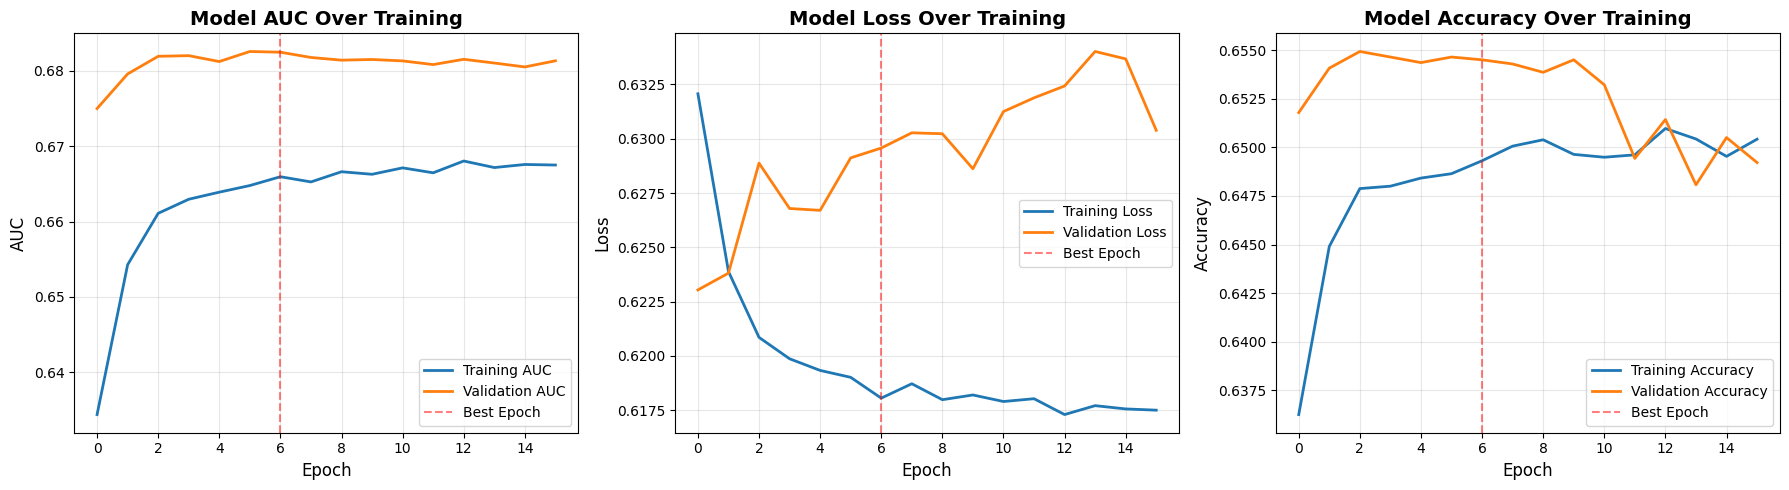


Training Summary:
  Best training AUC: 0.668031
  Best validation AUC: 0.682562
  Final training loss: 0.617499
  Final validation loss: 0.630389


In [ ]:
import matplotlib.pyplot as plt

# Find best epoch
best_epoch_idx = np.argmin(history.history['val_loss'])

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss (MOST IMPORTANT - should show both decreasing)
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].axvline(x=best_epoch_idx, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss Over Training (Key: Both Should Decrease)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: AUC
axes[0, 1].plot(history.history['auc'], label='Training AUC', linewidth=2, color='blue')
axes[0, 1].plot(history.history['val_auc'], label='Validation AUC', linewidth=2, color='orange')
axes[0, 1].axvline(x=best_epoch_idx, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('AUC', fontsize=12)
axes[0, 1].set_title('AUC Over Training', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Accuracy
axes[1, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[1, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[1, 0].axvline(x=best_epoch_idx, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Accuracy Over Training', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Learning Rate Schedule
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='green')
    axes[1, 1].axvline(x=best_epoch_idx, color='red', linestyle='--', alpha=0.7, label='Best Epoch')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate Not Tracked', 
                    ha='center', va='center', fontsize=14)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("TRAINING ANALYSIS")
print("=" * 80)
print(f"Best epoch (min val_loss): {best_epoch_idx + 1}")
print(f"Training loss at best epoch: {history.history['loss'][best_epoch_idx]:.6f}")
print(f"Validation loss at best epoch: {history.history['val_loss'][best_epoch_idx]:.6f}")
print(f"Gap (train - val): {history.history['loss'][best_epoch_idx] - history.history['val_loss'][best_epoch_idx]:.6f}")
print()
print(f"Best training AUC: {max(history.history['auc']):.6f}")
print(f"Best validation AUC: {max(history.history['val_auc']):.6f}")
print(f"Final validation AUC: {final_auc:.6f}")
print("=" * 80)

# Overfitting check
train_val_gap = history.history['loss'][best_epoch_idx] - history.history['val_loss'][best_epoch_idx]
if train_val_gap < 0.01:
    print("✅ GOOD: Minimal overfitting (train-val gap < 0.01)")
elif train_val_gap < 0.05:
    print("⚠️  MODERATE: Some overfitting (train-val gap 0.01-0.05)")
else:
    print("❌ BAD: Significant overfitting (train-val gap > 0.05)")
print("=" * 80)

## Summary

✅ **Test notebook complete!**

### What we did:

1. ✅ Loaded training data (60/20/20 split)
2. ✅ Loaded actual Stage 1 models from batch 1
3. ✅ Ran **`optimize_and_update_config()`** (same as online hill climbing)
4. ✅ Displayed optimized hyperparameters
5. ✅ Generated copy-paste config for `ensemble_config.py`

### Key points:

- **Shared code path**: Uses identical optimization function as online training
- **Real data**: Uses actual Stage 1 models from hill climbing run
- **GPU-optimized**: ~15-30 min on P100 GPU
- **Focused search**: pyramid/funnel architectures, 2-3 layers, 64-256 units
- **Conservative split**: 95% training (266k), 5% validation (14k)

### Next steps:

1. Copy the `STAGE2_DNN_CONFIG` above into `ensemble_config.py`
2. Run full hill climbing with GPU enabled
3. Architecture will be automatically optimized at batches 10, 20, 30+
4. Compare performance against baseline